In [ ]:
!pip install wikidata numpy datasets

import numpy as np
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
import requests
import re
from wikidata.client import Client
from datasets import load_dataset

from huggingface_hub import notebook_login


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
dataset_path = "/content/drive/MyDrive/SocioEmbeddings/data/csv_datasets/gold_dataset_clean.csv"
dataset = pd.read_csv(dataset_path, sep=",")
dataset.head()

,item,name,description,type,category,subcategory,label
0,Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive
1,Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative
2,Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative
3,Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative
4,Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative


In [ ]:
dataset.shape

(6238, 7)

Retrieve text from all articles (78m 34s)

# Pre - Trained Word2Vec

Load Google's Word2Vec stuff


In [ ]:
w2v_root = "/content/drive/MyDrive/SocioEmbeddings/data"

with open(f"{w2v_root}/w2v_key2index.pkl", "rb") as f:
    w2v_google_key2index = pickle.load(f)

w2v_embedding = torch.load(f"{w2v_root}/word2vec_embedding.pt")

display(w2v_google_key2index)
display(w2v_embedding)

{'</s>': 0,
 'in': 1,
 'for': 2,
 'that': 3,
 'is': 4,
 'on': 5,
 '##': 6,
 'The': 7,
 'with': 8,
 'said': 9,
 'was': 10,
 'the': 11,
 'at': 12,
 'not': 13,
 'as': 14,
 'it': 15,
 'be': 16,
 'from': 17,
 'by': 18,
 'are': 19,
 'I': 20,
 'have': 21,
 'he': 22,
 'will': 23,
 'has': 24,
 '####': 25,
 'his': 26,
 'an': 27,
 'this': 28,
 'or': 29,
 'their': 30,
 'who': 31,
 'they': 32,
 'but': 33,
 '$': 34,
 'had': 35,
 'year': 36,
 'were': 37,
 'we': 38,
 'more': 39,
 '###': 40,
 'up': 41,
 'been': 42,
 'you': 43,
 'its': 44,
 'one': 45,
 'about': 46,
 'would': 47,
 'which': 48,
 'out': 49,
 'can': 50,
 'It': 51,
 'all': 52,
 'also': 53,
 'two': 54,
 'after': 55,
 'first': 56,
 'He': 57,
 'do': 58,
 'time': 59,
 'than': 60,
 'when': 61,
 'We': 62,
 'over': 63,
 'last': 64,
 'new': 65,
 'other': 66,
 'her': 67,
 'people': 68,
 'into': 69,
 'In': 70,
 'our': 71,
 'there': 72,
 'A': 73,
 'she': 74,
 'could': 75,
 'just': 76,
 'years': 77,
 'some': 78,
 'U.S.': 79,
 'three': 80,
 'million': 81

tensor([[ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
         -1.2302e-04, -8.6308e-05],
        [ 7.0312e-02,  8.6914e-02,  8.7891e-02,  ..., -4.7607e-02,
          1.4465e-02, -6.2500e-02],
        [-1.1780e-02, -4.7363e-02,  4.4678e-02,  ...,  7.1289e-02,
         -3.4912e-02,  2.4170e-02],
        ...,
        [-1.9653e-02, -9.0820e-02, -1.9409e-02,  ..., -1.6357e-02,
         -1.3428e-02,  4.6631e-02],
        [ 3.2715e-02, -3.2227e-02,  3.6133e-02,  ..., -8.8501e-03,
          2.6978e-02,  1.9043e-02],
        [ 4.5166e-02, -4.5166e-02, -3.9368e-03,  ...,  7.9590e-02,
          7.2266e-02,  1.3000e-02]])

For every item in the dataset, I will take the average of the words in the Wikipedia Article

In [ ]:
from huggingface_hub import login

token = ""

# non spuntare add token as git credential
login(token=token)


In [ ]:
dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
display(len(dataset['train']))
display(len(dataset['validation']))

6251

300

In [ ]:
train, test = dataset["train"], dataset["validation"]

In [ ]:
class WikiScraper:
    def __init__(self, dataset, wikidata_client, text_path, dictionary_path, load=False, load_dictionary_path=None):

        """
        Args:
            dataset - Dataset that contains the informations we want
            wikidata_client - wikidata.Client(), used to scrape the content in the WikiData pages
            output_path - Path to the file that will be saved by the scraper e.g. /home/wikidata/wiki.pkl
            load - skips the scraping and loads data from the file in load_file_path
        """
        self.wikidat_client = wikidata_client
        self.TEXT_OUTPUT = text_path
        self.DICTIONARY_OUTPUT = dictionary_path
        self.dataset = dataset

        self.entities_id = self.retrieve_entities()
        self.entity2row = self.entity_to_row()

        if(load == True):
            if(not load_dictionary_path):
                raise Exception("Load Path must be a valid path if load=True")
            with open(load_dictionary_path, "rb") as f:

                try:
                    self.wikidict = pickle.load(f)
                except:
                    raise Exception("File cannot be loaded")
        else:
            try:
                os.makedirs(os.path.dirname(self.TEXT_OUTPUT), exist_ok=True)
            except:
                raise Exception(f"{self.TEXT_OUTPUT} already exists")

            try:
                os.makedirs(os.path.dirname(self.DICTIONARY_OUTPUT), exist_ok=True)
            except:
                raise Exception(f"{self.DICTIONARY_OUTPUT}already exists")
            self.wikidict = self.retrieve_wikidict()


    def extract_id(self, link):
        """
        Retrieves the entity id from the "item" column in the dataset, which is a Wikidata link.

            Args:
            link - the link column
        """
        return link.split("/")[-1]

    def retrieve_entities(self):

        """Retrieves all the Wikidata IDs from the dataset."""
        res = []
        for row in self.dataset:
            # item is the column relative to the wikidata link
            item = row["item"]
            res.append(self.extract_id(item))
        return res

    def entity_to_row(self):
        """Creates the dictionary entity_id: row_number"""
        dic={}
        for index, row in enumerate(self.dataset):
            item = row["item"]
            entity = self.extract_id(item)

            dic[entity] = index

        return dic

    def retrieve_wikidict(self):
        """
        Function that scrapes WikiData pages for the items in the dataset <br>
        It does two things: <br>
            1. returns a dictionary with the format
            entity_id: wikipedia_article. <br>
            2. it creates a file to OUTPUT_PATH containing all the text scraped from Wikipedia related articles

            Args:
            entities_id: list of entities id from Wikidata
        """

        entities_id = self.entities_id
        # Wikidata client instantiation
        client = Client()

        # Useful sub-functions
        def clean_wikipedia_extract(text):
            """Sub-function that cleans wikipedia text"""

            # Remove unwanted paragraphs

            text = re.sub(r"^==.*?==\s*", "", text, flags=re.MULTILINE)

            end_markers = ["See also", "References", "External links", "Further reading"]
            for marker in end_markers:
                pattern = rf"==\s*{marker}\s*==.*"
                text = re.sub(pattern, "", text, flags=re.IGNORECASE | re.DOTALL)

            text = text.replace("\n", " ")
            text = text.replace("\t", " ")
            return text.strip()

        def get_text(item):
            """
            Sub-function that handles the get request from Wikipedia

            Arguments:
            item -- wikidata.Entity
            """
            sitelinks = item.data.get("sitelinks", {})
            enwiki = sitelinks.get("enwiki")
            if enwiki:
                title = enwiki["title"]

                api_url = "https://en.wikipedia.org/w/api.php"
                params = {
                    "action": "query",
                    "prop": "extracts",
                    "explaintext": True,
                    "titles": title,
                    "format": "json",
                    "redirects": 1
                }

                res = requests.get(api_url, params=params).json()
                pages = res.get("query", {}).get("pages", {})
                if not pages:
                    return ""
                page = next(iter(pages.values()))
                text = page.get("extract", "")
                text = text.lower()
                text = clean_wikipedia_extract(text)
                return text
            else:
                print(f"No English Wikipedia page found for entity . (skipping)")
            return ""


        tot = len(entities_id)
        dic = {}

        # Save related Wikidata text to output_path
        # and create the dictionary entity: wikipedia article
        with open(self.TEXT_OUTPUT, "a") as f:

            for entity_id in tqdm(entities_id, total=tot):
                item = client.get(entity_id, load = True)
                text = get_text(item)
                dic[entity_id] = text
                text+="\n"
                f.write(text)

        with open(self.DICTIONARY_OUTPUT, "wb") as f:
            pickle.dump(dic, f)

        return dic


In [ ]:
with open(f"{w2v_root}/wikidict.pkl", "rb") as f:
  wikidict = pickle.load(f)

Train a Classifier for each item in the dataset. We take the Wikipedia article for the item and embed each word using Google's Word2Vec. For each article we take the Average and this will be passed to a fully connected layer that will output one of the three categories.

# Dataset Creation


In [ ]:
embedding_root = "/content/drive/MyDrive/SocioEmbeddings/data/text_graph/graph/"
graph_root = "/content/drive/MyDrive/SocioEmbeddings/data/text_graph/graph"

In [ ]:
with open(f'{w2v_root}/graph_dictionary.pkl', "rb") as f:
  graph_dictionary = pickle.load(f)

with open(f"{w2v_root}/graph2idx.pkl", "rb") as f:
  graph2idx = pickle.load(f)

graph_embedding = torch.load(f"{w2v_root}/graph_embedding.pt")

In [ ]:
import torch
import re
from torch.nn.utils.rnn import pad_sequence

LABEL2ID = {
    "cultural representative": 0,
    "cultural agnostic": 1,
    "cultural exclusive": 2
}

class WikiGraphDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, wikidict, w2v_key2index, graph2idx, graph_dict):
        self.pattern = re.compile(r"\W+")

        # Build WikiDataset-like structure
        wiki_samples = []
        for row in dataset:
            qid = row["item"].split("/")[-1]
            label_str = row["label"]

            if qid not in wikidict or label_str not in LABEL2ID:
                continue

            text = wikidict[qid]
            tokens = [w for w in self.pattern.split(text.lower()) if w]
            encoded = [w2v_key2index[w] for w in tokens if w in w2v_key2index]

            if not encoded:
                continue

            wiki_samples.append({
                "input": torch.tensor(encoded, dtype=torch.long),
                "target": torch.tensor(LABEL2ID[label_str], dtype=torch.long),
                "qid": qid
            })

        # Build GraphDataset-like structure
        graph_index_map = {}
        for qid in [sample["qid"] for sample in wiki_samples]:
            if qid in graph_dict:
                indices = []
                if qid in graph2idx:
                    indices.append(graph2idx[qid])

                for prop in graph_dict[qid].get("properties"):
                    if prop in graph2idx:
                        indices.append(graph2idx[prop])

                for entity in graph_dict[qid].get("entities"):
                    if entity in graph2idx:
                        indices.append(graph2idx[entity])

                if indices:
                    graph_index_map[qid] = torch.tensor(indices, dtype=torch.long)

        # Final combined samples
        self.samples = [
            {
                "input": sample["input"],
                "target": sample["target"],
                "graph": graph_index_map[sample["qid"]]
            }
            for sample in wiki_samples
            if sample["qid"] in graph_index_map
        ]

    def __getitem__(self, idx):
        return self.samples[idx]

    def __len__(self):
        return len(self.samples)

    def collate_fn(self, batch):
        inputs = [b["input"] for b in batch]
        graphs = [b["graph"] for b in batch]
        targets = [b["target"] for b in batch]

        padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
        padded_graphs = pad_sequence(graphs, batch_first=True, padding_value=0)
        targets = torch.tensor(targets, dtype=torch.long)
        return {"wiki": padded_inputs, "graph": padded_graphs, "target": targets}


In [ ]:
from torch.utils.data import DataLoader

wikigraph_train = WikiGraphDataset(train, wikidict, w2v_google_key2index, graph2idx, graph_dictionary)
wikigraph_test = WikiGraphDataset(test, wikidict, w2v_google_key2index, graph2idx, graph_dictionary)

In [ ]:
wikigraph_train_loader = DataLoader(wikigraph_train, collate_fn=wikigraph_train.collate_fn, batch_size=8)
wikigraph_test_loader = DataLoader(wikigraph_test, collate_fn=wikigraph_test.collate_fn, batch_size = 8)

In [ ]:
total_train_batches = 0
total_test_batches = 0

for i in wikigraph_train_loader:
    total_train_batches+=1

for i in wikigraph_test_loader:
    total_test_batches+=1

print(f"Total train batches: {total_train_batches}\nTotal test batches: {total_test_batches}")


Total train batches: 782.
Total test batches: 38


In [ ]:
for i, elem in enumerate(wikigraph_train_loader):
  if(i==2):
    break
  print(elem["graph"].shape)

torch.Size([8, 647])
torch.Size([8, 809])


Model definition


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CulturalClassifier(nn.Module):
    def __init__(self, word_embedding, graph_embedding, embedding_size):
        super().__init__()

        self.word_embedding = nn.Embedding.from_pretrained(word_embedding, padding_idx=0)
        self.graph_embedding = nn.Embedding.from_pretrained(graph_embedding, padding_idx=0)
        self.alpha = nn.Parameter(torch.tensor(0.5))  # for word
        self.beta = nn.Parameter(torch.tensor(0.5))   # for graph

        self.output = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(embedding_size, 150),
            nn.ReLU(),
            nn.Linear(150, 150),
            nn.ReLU(),
            nn.Linear(150,3)
        )

    def forward(self, input, graph):
      """
      input: (batch_size, seq_len)       -- word indices
      graph: (batch_size, num_nodes)     -- graph node indices (with 0 as padding)
      """

      weights = F.softmax(torch.stack([self.alpha, self.beta]), dim=0)
      alpha = weights[0]
      beta = weights[1]

      # Retrieve Embeddings
      word_embeddings = self.word_embedding(input) #(batch, seq_len, emb)
      graph_embs = self.graph_embedding(graph)  #(batch, nodes, emb)


    # Calculate Mean for the Graph Embedding without weighting the padded tokens
      # Mask for padding
      graph_mask = (graph != 0).unsqueeze(-1).float()  #(batch, nodes, 1)  1 if non zero, 0 otherwise

      summed = (graph_embs * graph_mask).sum(dim=1)  #(batch, emb)

      # Count valid (non-zero) values, clamp so that no division by 0
      counts = graph_mask.sum(dim=1).clamp(min=1)    #(batch, 1)

      # Average of graph embedding without counting the padding
      mean_graph_emb = summed / counts #(batch, emb)


    # Calculate Mean for the Word Embedding without weighting the padded tokens

      # Word embedding mask
      word_mask = (input != 0).unsqueeze(-1).float() #(batch, seq_len, 1)

      # Mask word embeddings before combining
      masked_word_embeddings = word_embeddings * word_mask  # (B, L, D)

      #Average of tgext embedding without counting the padding clamp so that no division by 0
      mean_word_emb = (masked_word_embeddings * word_mask).sum(dim=1) / word_mask.sum(dim=1).clamp(min=1)

      # Combine embeddings
      combined = alpha*mean_word_emb + beta*mean_graph_emb

      # Output layer
      output = self.output(combined)  # (B, 3)

      return output



In [ ]:
class EarlyStopping():
  def __init__(self, patience=10, min_delta=0.01, maximize=True):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_score = None
    self.maximize = maximize

  def early_stop(self, score):
    if self.best_score is None:
      self.best_score = score
    elif (self.maximize and score > self.best_score - self.min_delta) or (not self.maximize and score < self.best_score + self.min_delta):
      self.counter = 0
      self.best_score = score
    else:
      self.counter += 1

      if self.counter >= self.patience:
        return True
    return False


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

class Trainer():

    def __init__(self, model, train_loader, test_loader, optimizer, loss, early_stop = None, device="cpu"):

        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.loss = loss
        self.device = device
        self.train_batches = self._calculate_batches(train_loader)
        self.test_batches = self._calculate_batches(test_loader)
        self.early_stopper = early_stop

    def _calculate_batches(self, dataset):

        count = 0
        for i in dataset:
            count+=1
        return count

    def train(self, epochs, evaluate_interval = None):


        self.model = self.model.to(self.device)

        train_loss = 0.0
        train_history = []
        test_history = []
        best_f1 = 0
        for epoch in range(epochs):
            epoch_loss = 0.0
            num_batches = 0
            for batch in tqdm(self.train_loader, total = self.train_batches):
                input, target, graph = batch["wiki"], batch["target"], batch["graph"]

                input = input.to(self.device)
                target = target.to(self.device)
                graph = graph.to(self.device)

                output = self.model(input, graph)
                loss = self.loss(output, target)

                self.optimizer.zero_grad()

                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1
                del input, target, graph, output, loss


            avg_loss = epoch_loss / num_batches
            train_history.append(avg_loss)

            test_loss,accuracy, macro_f1 = self.evaluate(self.test_loader)
            test_history.append(test_loss)
            if(evaluate_interval != None and epoch % evaluate_interval == 0):
              print(f'Epoch: {epoch} avg train loss = {avg_loss:.5f}, avg test loss = {test_loss:.5f}, accuracy = {accuracy:.5f}, f1 = {macro_f1:.5f}')
            else:
                print(f'Epoch: {epoch} avg loss = {avg_loss:.5f}')

            # Early Stopping
            if self.early_stopper.early_stop(macro_f1):
              print("Early Stopping...")
              break

             # Save the model if it performs better (based on F1 score)
            if macro_f1 > best_f1:
              best_f1 = macro_f1
              best_model_state = self.model.state_dict()

            train_loss += avg_loss

        avg_loss = train_loss / epochs
        if best_model_state is not None:
          self.model.load_state_dict(best_model_state)
          print(f"Loaded the best model based on F1 score. {best_f1}")
        return train_history, test_history

    @torch.no_grad()
    def evaluate(self, test_set):
        self.model = self.model.to(self.device)
        self.model.eval()

        all_predictions = []
        all_targets = []

        total_loss = 0.0
        total_batches = self._calculate_batches(test_set)

        for batch in tqdm(test_set, total=total_batches):
            input, target, graph = batch["wiki"], batch["target"], batch["graph"]

            input = input.to(self.device)
            target = target.to(self.device)
            graph = graph.to(self.device)

            output = self.model(input, graph)

            loss = self.loss(output, target)
            total_loss += loss.item()

            preds = torch.argmax(output, dim=1).cpu().numpy()
            true = target.cpu().numpy()

            all_predictions.extend(preds)
            all_targets.extend(true)

            del input, target, graph, output, loss

        accuracy = accuracy_score(all_targets, all_predictions)
        macro_f1 = f1_score(all_targets, all_predictions, average='macro')

        # Final cleanup
        import gc
        gc.collect()
        torch.cuda.empty_cache()

        return total_loss / total_batches, accuracy, macro_f1


    def report(self):
        self.model = self.model.to(self.device)
        self.model.eval()

        all_predictions = []
        all_targets = []

        total_loss = 0.0
        total_batches = self._calculate_batches(self.test_loader)
        for batch in tqdm(self.test_loader, total=total_batches):
            input, target, graph = batch["wiki"], batch["target"], batch["graph"]

            input = input.to(self.device)
            target = target.to(self.device)
            graph = graph.to(self.device)

            output = self.model(input, graph)

            loss = self.loss(output, target)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(output, dim=1)  # Adjust if it's binary or multilabel

            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            del input, target, graph, output, loss

        # Final cleanup after evaluation
        import gc
        gc.collect()
        torch.cuda.empty_cache()

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions, digits=4))  # Adjust labels if needed

        # Plot confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

In [ ]:
# Run when colab's RAM is full
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc

del cultural_classifier

gc.collect()

0

In [ ]:
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
cultural_classifier = CulturalClassifier(w2v_embedding, graph_embedding, 300)

device = "cuda" if torch.cuda.is_available() else "cpu"

label2id = {
    "cultural exclusive": 0,
    "cultural agnostic": 1,
    "cultural representative" : 2
}

id2label = {
    0: "cultural exclusive",
    1: "cultural agnostic",
    2: "cultural representative"
}
labels = [label2id[item["label"]] for item in train]

# We apply weights to the classes in order to mitigate the unbalancement between them
class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1, 2]), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

class_weights_tensor

tensor([0.7743, 1.1131, 1.2344])

In [ ]:
cultural_classifier = CulturalClassifier(w2v_embedding, graph_embedding, 300)
cultural_classifier.load_state_dict(torch.load(f"/content/drive/MyDrive/SocioEmbeddings/data/text_graph/classifier.pt", weights_only=True))
cultural_classifier.to(device)
                                                                #0.0001              1e-5
optimizer = torch.optim.Adam(cultural_classifier.parameters(), lr=0.0001, weight_decay=1e-7)
criterion = torch.nn.CrossEntropyLoss()

trainer = Trainer(
    model=cultural_classifier,
    train_loader=wikigraph_train_loader,
    test_loader=wikigraph_test_loader,
    optimizer=optimizer,
    loss=criterion,
    early_stop=EarlyStopping(patience=10, min_delta=0.001, maximize=True),
    device=device
)

In [ ]:
# ! If you want to run the training, remove the comment
# train_history, test_history = trainer.train(epochs = 150, evaluate_interval=1)


In [ ]:
cultural_classifier.state_dict()

OrderedDict([('alpha', tensor(0.6121, device='cuda:0')),
             ('beta', tensor(0.3879, device='cuda:0')),
             ('word_embedding.weight',
              tensor([[ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
                       -1.2302e-04, -8.6308e-05],
                      [ 7.0312e-02,  8.6914e-02,  8.7891e-02,  ..., -4.7607e-02,
                        1.4465e-02, -6.2500e-02],
                      [-1.1780e-02, -4.7363e-02,  4.4678e-02,  ...,  7.1289e-02,
                       -3.4912e-02,  2.4170e-02],
                      ...,
                      [-1.9653e-02, -9.0820e-02, -1.9409e-02,  ..., -1.6357e-02,
                       -1.3428e-02,  4.6631e-02],
                      [ 3.2715e-02, -3.2227e-02,  3.6133e-02,  ..., -8.8501e-03,
                        2.6978e-02,  1.9043e-02],
                      [ 4.5166e-02, -4.5166e-02, -3.9368e-03,  ...,  7.9590e-02,
                        7.2266e-02,  1.3000e-02]], device='cuda:0')),
             ('

100%|██████████| 782/782 [00:00<00:00, 959.18it/s] 



Classification Report:
              precision    recall  f1-score   support

           0     0.7783    0.6552    0.7115      1688
           1     0.8295    0.8974    0.8621      1871
           2     0.8181    0.8528    0.8351      2690

    accuracy                         0.8128      6249
   macro avg     0.8087    0.8018    0.8029      6249
weighted avg     0.8108    0.8128    0.8098      6249



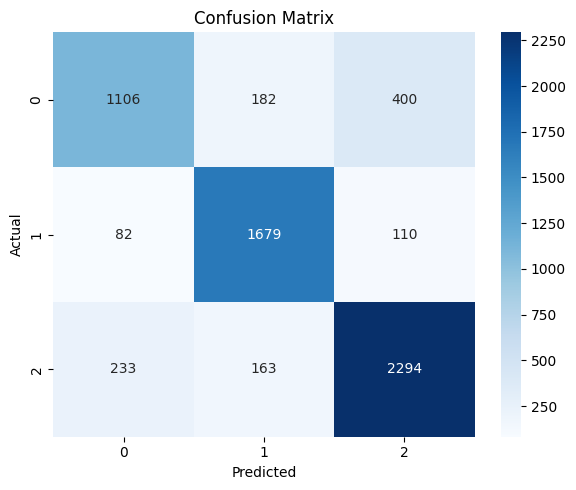

In [ ]:
trainer.report()

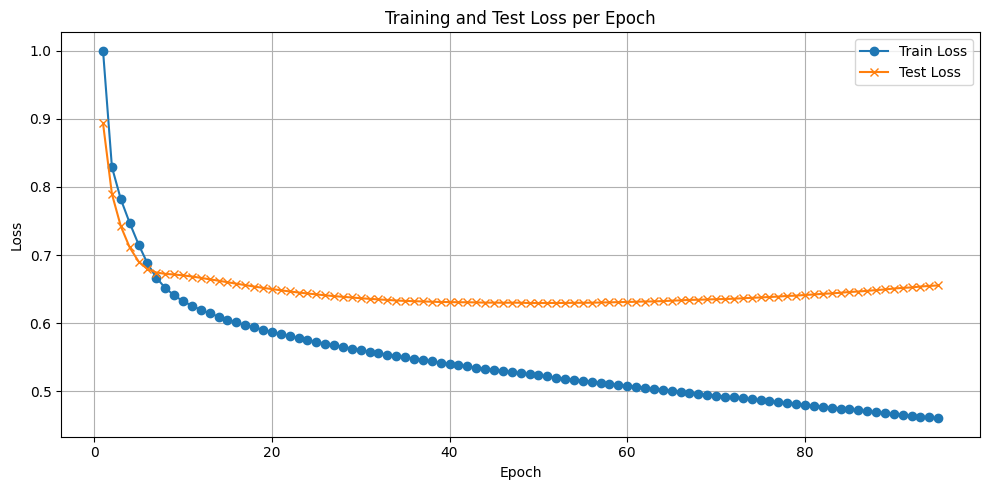

In [ ]:
import matplotlib.pyplot as plt

# Assume losses are collected after training:
# train_losses, test_losses = trainer.train(epochs=10)

epochs = range(1, len(train_history) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_history, label='Train Loss', marker='o')
plt.plot(epochs, test_history, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
avg_train_loss = trainer.evaluate(wikigraph_test_loader)
avg_train_loss

100%|██████████| 19/19 [00:00<00:00, 272.42it/s]


(0.6556016743967408, 0.75, 0.738824153082342)

In [ ]:
cultural_classifier.state_dict()

OrderedDict([('alpha', tensor(0.6121, device='cuda:0')),
             ('beta', tensor(0.3879, device='cuda:0')),
             ('word_embedding.weight',
              tensor([[ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
                       -1.2302e-04, -8.6308e-05],
                      [ 7.0312e-02,  8.6914e-02,  8.7891e-02,  ..., -4.7607e-02,
                        1.4465e-02, -6.2500e-02],
                      [-1.1780e-02, -4.7363e-02,  4.4678e-02,  ...,  7.1289e-02,
                       -3.4912e-02,  2.4170e-02],
                      ...,
                      [-1.9653e-02, -9.0820e-02, -1.9409e-02,  ..., -1.6357e-02,
                       -1.3428e-02,  4.6631e-02],
                      [ 3.2715e-02, -3.2227e-02,  3.6133e-02,  ..., -8.8501e-03,
                        2.6978e-02,  1.9043e-02],
                      [ 4.5166e-02, -4.5166e-02, -3.9368e-03,  ...,  7.9590e-02,
                        7.2266e-02,  1.3000e-02]], device='cuda:0')),
             ('

In [ ]:
torch.save(cultural_classifier.state_dict(), f"{w2v_root}/cultural_classifier/classifier.pt")

In [ ]:
trainer_config = {
    "model_class": cultural_classifier.__class__.__name__,
    "embedding_dim": 300,
    "learning_rate": 0.0001,
    "weight_decay": 1e-7,
    "loss": "CrossEntropyLoss",
    "optimizer": "Adam",
    "early_stop": {
        "patience": 10,
        "min_delta": 0.001,
        "maximize": True
    },
    "device": str(device),
    "train_loader_len": len(wikigraph_train_loader),
    "test_loader_len": len(wikigraph_test_loader)
}
import json
with open(f"{w2v_root}/cultural_classifier/trainer_config.json", "w") as f:
    json.dump(trainer_config, f, indent=4)